Install Needed Packeges

In [1]:
# !conda install -c conda-forge geocoder
# !conda install -c conda-forge folium=0.5.0 --yes
# !conda install -c anaconda requests
# !conda install -c anaconda beautifulsoup4
# !conda install -c anaconda lxml

Import Needed Packeges

In [2]:
import geocoder # import geocoder
from geopy.geocoders import Nominatim # convert an address into latitude and long

import folium # map rendering library
from folium import plugins
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap
from folium.features import DivIcon

import requests # for making HTTP requests in Python
import pandas as pd # providing high-performance, easy-to-use data structures 
import matplotlib.pyplot as plt
from matplotlib.pyplot import *

import numpy as np # library to handle data in a vectorized manner
from pandas.io.json import json_normalize
from urllib.request import urlopen
import json
from sklearn.cluster import KMeans # import k-means from clustering stage
from bs4 import BeautifulSoup # for pulling data out of HTML and XML files
import geopy.distance
import matplotlib.colors as colors # A module for converting numbers or color arguments to RGB or RGBA

## Get Abu Dhabi City GeoLocation using Nominatim

In [3]:
address = 'Abu Dhabi, Abu Dhabi, United Arab Emirates'
geolocator = Nominatim(user_agent="ADZss")
location = geolocator.geocode(address)
ADLat = location.latitude
ADLong = location.longitude
print((ADLat,ADLong ))

(24.39647445, 54.5366630864359)


Show Adu Dhabi Map

In [4]:
folium.Map(location=[ADLat, ADLong],zoom_start=11)

## Get Post Offices in Dhabi City
i will use two methods to retrive post offices in Abu Dhabi<br>
1- Foursquare.com with radius 50 Km of Abu dhabi city location<br>
2- The UAE official Open Data Portal (Bayanat.ae)

#### 1- Foursquare

In [5]:
CLIENT_ID = 'SETXCY5U2AK53ES13PY4SUB0IK4YQPFGSFXCKOCIUADQJ1U1' # your Foursquare ID
CLIENT_SECRET = 'S3IGI0LFO01E2UHCD5CXLK21K0VAMBWUGMSNVBFT5POUUXTK' # your Foursquare Secret
VERSION = '20180604' # Foursquare API version

radius = 50000
LIMIT = 500
search_query = 'Post Office'
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, ADLat, ADLong, VERSION, search_query, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=SETXCY5U2AK53ES13PY4SUB0IK4YQPFGSFXCKOCIUADQJ1U1&client_secret=S3IGI0LFO01E2UHCD5CXLK21K0VAMBWUGMSNVBFT5POUUXTK&ll=24.39647445,54.5366630864359&v=20180604&query=Post Office&radius=50000&limit=500'

In [6]:
results = requests.get(url).json()
# results

In [7]:
# assign relevant part of JSON to venues
postOffices = results['response']['venues']

# tranform venues into a dataframe
Foursquare_df = json_normalize(postOffices)
# Foursquare_df.head()

In [8]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [9]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories','location.lat','location.lng']  #+ [col for col in Foursquare_df.columns if col.startswith('location')] + ['id']
Foursquare_df_filtered = Foursquare_df.loc[:, filtered_columns]

# filter the category for each row
# Foursquare_df_filtered['categories'] = Foursquare_df_filtered.apply(get_category_type, axis=1)
Foursquare_df_filtered = Foursquare_df_filtered[Foursquare_df_filtered['name'].str.contains("Post Office") | Foursquare_df_filtered['categories'].str.contains("Post Office")]

Foursquare_df_filtered.drop(columns=['categories'], inplace=True)
Foursquare_df_filtered.rename(columns={"location.lat": "lat", "location.lng": "lng"}, inplace=True)

# Foursquare_df_filtered.head()

#### Bayanat.ae
Bayanat.ae The UAE official Open Data Portal provides enhanced open data systems for public use, 
http://data.bayanat.ae/en_GB/dataset/emirates-post-offices-gis-location

In [10]:
bayanatURL = "http://data.bayanat.ae/api/action/datastore_search?resource_id=44d831dc-2c88-4b37-bc1d-57ab680181df&q=Dhabi"
results = requests.get(bayanatURL).json()

bayanat_df = json_normalize(results["result"]["records"])
# bayanat_df.head()

In [11]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['Branch postoffice name', 'updated Longitude','updated Latitude']
filtered_bayanat_df = bayanat_df.loc[:, filtered_columns]

filtered_bayanat_df.rename(columns={"Branch postoffice name": "name", "updated Longitude": "lng", "updated Latitude": "lat"}, inplace=True)
# filtered_bayanat_df.dtypes

In [12]:
filtered_bayanat_df = filtered_bayanat_df.astype({"name": str, "lng": float,"lat": float})
# filtered_bayanat_df.dtypes

##### Plot Post offices retrived from <font color='blue'>Foursquare</font> and <font color='orange'>bayanat.ae</font> 

In [13]:
postOffices_map = folium.Map(location=[ADLat, ADLong], zoom_start=11)

# add the post Offices as blue circle markers
for lat, lng, label in zip(Foursquare_df_filtered.lat, Foursquare_df_filtered.lng, Foursquare_df_filtered.name):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(postOffices_map)

for lat, lng, label in zip(filtered_bayanat_df.lat, filtered_bayanat_df.lng, filtered_bayanat_df.name):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='orange',
        popup=label,
        fill = True,
        fill_color='orange',
        fill_opacity=0.6
    ).add_to(postOffices_map)
# display map
postOffices_map

Analysing Plotted Post Office GeoLocations from Plot Post offices retrived from <font color='blue'>Foursquare</font> and <font color='orange'>bayanat.ae</font> <br>

- bayanat.ae have more data
- Foursquare have Doublicates 
 - 2 locations for Butain Post Office
 - 2 locations for Khalidiya Post Office
 - 2 locations for Abu Dhabi Central Post Office
 - 2 locations for Hamdan Post Office
 
 Thus we will carry on using Data from bayanat.ae

### Data Cleanup

#### 1- Drop Post Offices outside Abu Dhabi City

In [14]:
coords_1 = (ADLat, ADLong)
filtered_bayanat_df["distance"]=np.nan

for index, row in filtered_bayanat_df.iterrows():
    coords_2 = (row["lat"], row["lng"])
    distance=geopy.distance.geodesic(coords_1, coords_2).km
    filtered_bayanat_df.loc[index, 'distance'] = distance
    
filtered_bayanat_df.head()

,name,lng,lat,distance
0,Tam Centre - Zayed City Post Office,53.700222,23.674578,116.758158
1,Zayed City Post Office,53.702538,23.659077,117.774249
2,Tam Centre - Ghayathi Post Office,52.809547,23.849718,185.718252
3,Tam Centre - Liwa Post Office,53.798080,23.131104,159.087667
4,Al Nadi Sayahi Post Office,54.379688,24.498306,19.508143


In [15]:
# Drop all rows where distance is greater than 50Km (50000m radius)
filtered_bayanat_df.drop(filtered_bayanat_df[filtered_bayanat_df['distance'] > 50 ].index , inplace=True)
filtered_bayanat_df

,name,lng,lat,distance
4,Al Nadi Sayahi Post Office,54.379688,24.498306,19.508143
5,Bani Yas Post Office,54.643620,24.285358,16.410080
7,Hamdan Post Office,54.366886,24.496719,20.485225
9,Al Falah Post Office,54.379513,24.481054,18.485430
10,Al Musafah Post Office,54.521702,24.377821,2.563666
12,Al Butain Post Office,54.349064,24.459110,20.250433
13,Al Rahba Post Office,54.694187,24.576313,25.529641
14,Khalidiya Post Office,54.340950,24.469082,21.414531
15,Sheikh Khalifa Medical City Post Office,54.364971,24.468798,19.165585
16,Shabiyat Musafah Post Office,54.532993,24.332832,7.059090


In [16]:
print ("Post Offices from Bayanat.ae:{}\nPost Offices from Foursquare:{}".format(filtered_bayanat_df.shape[0],Foursquare_df_filtered.shape[0])) 

Post Offices from Bayanat.ae:16
Post Offices from Foursquare:16


In [17]:
# Drop "distance" Column 
filtered_bayanat_df.drop(columns=['distance'], inplace=True)

Drop "Abu Dhabi International Airport Post Office"

In [18]:
filtered_bayanat_df.drop(filtered_bayanat_df[filtered_bayanat_df['name'] == 'Abu Dhabi International Airport Post Office'].index , inplace=True)
filtered_bayanat_df

,name,lng,lat
4,Al Nadi Sayahi Post Office,54.379688,24.498306
5,Bani Yas Post Office,54.643620,24.285358
7,Hamdan Post Office,54.366886,24.496719
9,Al Falah Post Office,54.379513,24.481054
10,Al Musafah Post Office,54.521702,24.377821
12,Al Butain Post Office,54.349064,24.459110
13,Al Rahba Post Office,54.694187,24.576313
14,Khalidiya Post Office,54.340950,24.469082
15,Sheikh Khalifa Medical City Post Office,54.364971,24.468798
16,Shabiyat Musafah Post Office,54.532993,24.332832


In [19]:
print ("Row Counts:{}".format(filtered_bayanat_df.shape[0])) 

Row Counts:15


#### 1- Clean up names, remove "Emirates Post - "

In [20]:
# filtered_bayanat_df2 = filtered_bayanat_df
# filtered_bayanat_df2['name']

In [21]:
# filtered_bayanat_df2.loc[:, 'name'].replace(regex=True, to_replace=["Emirates Post - ", "Tam Centre - "], value="",inplace=True)
# filtered_bayanat_df2['name']

## Get Neighbourhoods of Dhabi City
https://en.wikipedia.org/wiki/Abu_Dhabi contains list of Dhabi City Neighbourhoods

we will use BeautifulSoup to scrap the wikipedia page for list of Neighbourhoods

In [22]:
url = "https://en.wikipedia.org/wiki/Abu_Dhabi"
response = requests.get(url)

soup = BeautifulSoup(response.text, 'lxml')

table = soup.find('div', attrs={'class':'div-col columns column-width','style':'-moz-column-width: 18em; -webkit-column-width: 18em; column-width: 18em;'})

# print(table)

res = []
ul = table.find('ul')
for li in ul.find_all('li'):
    res.append(li.a.get('title'))

df_ADNeighbourhoods = pd.DataFrame(res, columns=["Neighborhood"])

In [23]:
df_ADNeighbourhoods.head()

,Neighborhood
0,Al Aman (page does not exist)
1,Al Bateen (page does not exist)
2,Al Dhafrah (page does not exist)
3,Al Falah (page does not exist)
4,"Al Karama, United Arab Emirates"


In [24]:
print ("Row Counts:{}".format(df_ADNeighbourhoods.shape[0])) 

Row Counts:43


### Data Cleanup

#### 1- Cleanup Neighborhood Name
remove (page does not exist)" from Neighborhood Name<br>
fix Neighborhood names 

In [25]:
df_ADNeighbourhoods.loc[:, 'Neighborhood'].replace(regex=True, to_replace=[", United Arab Emirates"," \(page does not exist\)"," \(Abu Dhabi\)"," neighbourhood"], value="",inplace=True)

df_ADNeighbourhoods.loc[:, 'Neighborhood'].replace(regex=True, to_replace=["Al Karama"], value="Al Karamah",inplace=True)
df_ADNeighbourhoods.loc[:, 'Neighborhood'].replace(regex=True, to_replace=["Al Maqtaa"], value="Al Maqta",inplace=True)
df_ADNeighbourhoods.loc[:, 'Neighborhood'].replace(regex=True, to_replace=["Al Meena"], value="Al Mina",inplace=True)
df_ADNeighbourhoods.loc[:, 'Neighborhood'].replace(regex=True, to_replace=["Al Moroor"], value="Al Muroor",inplace=True)
df_ADNeighbourhoods.loc[:, 'Neighborhood'].replace(regex=True, to_replace=["Al Khalidyah"], value="al khalidiya",inplace=True)


### Get Neighbourhoods GeoLocations

In [26]:
# Add Columns for latitude and longitude
df_ADNeighbourhoods["lat"]=np.nan
df_ADNeighbourhoods["lng"]=np.nan

In [27]:
# use Nominatim to get Neighbourhoods GeoLocation

geolocator = Nominatim(user_agent="ADZss")
for index, row in df_ADNeighbourhoods.iterrows():
    address = "{},Abu Dhabi, United Arab Emirates".format(row["Neighborhood"])
    try:
        location = geolocator.geocode(address, timeout=10)
        df_ADNeighbourhoods.at[index, 'lat'] = location.latitude
        df_ADNeighbourhoods.at[index, 'lng'] = location.longitude
    except AttributeError:
        pass
#         print("at index: {}, {} : Problem with data or cannot Geocode.".format(index,row["Neighborhood"]))

    
    


In [28]:
#Add Missing Locations (Available on References)
df_ADNeighbourhoods.at[1,['lat','lng']]= {24.4513155,54.328144}

df_ADNeighbourhoods.at[9,['lat','lng']]= {24.453333, 54.363889}
df_ADNeighbourhoods.at[16,['lat','lng']]= {24.4081379,54.4338398}
df_ADNeighbourhoods.at[19,['lat','lng']]= {24.4596244,54.3190142}
df_ADNeighbourhoods.at[25,['lat','lng']]= {24.3063479,54.5995936}
df_ADNeighbourhoods.at[26,['lat','lng']]= {24.4667598,54.356339}
df_ADNeighbourhoods.at[31,['lat','lng']]= {24.417739,54.3576465}
df_ADNeighbourhoods.at[33,['lat','lng']]= {24.4772307,54.3179553}
df_ADNeighbourhoods.at[40,['lat','lng']]= {24.4261292,54.380629}
df_ADNeighbourhoods.at[42,['lat','lng']]= {24.695833,54.676111}

df_ADNeighbourhoods.drop(df_ADNeighbourhoods[df_ADNeighbourhoods['Neighborhood'] == 'Al Qubesat'].index , inplace=True)
df_ADNeighbourhoods.drop(df_ADNeighbourhoods[df_ADNeighbourhoods['Neighborhood'] == 'Al Rehhan'].index , inplace=True)
# Drop 18
# Drop 22
# 25 	Bani Yas, 24.3063479,54.5995936, https://www.google.com/maps/place/Bani+Yas+-+Abu+Dhabi/@24.3063479,54.5995936,13z/data=!3m1!4b1!4m5!3m4!1s0x3e5e371c349ddf2f:0xa49228e3d5f7c257!8m2!3d24.3105884!4d54.643093
# 26 	Al Zaab,24.4667598,54.356339 ,https://www.google.com/maps/place/Al+Zaab+-+Abu+Dhabi/@24.4667598,54.356339,16z/data=!3m1!4b1!4m5!3m4!1s0x3e5e6610cb4267f7:0xbed72ca9fe455d82!8m2!3d24.4653511!4d54.3617472
# 31 	Hideriyyat, 24.4071002,54.3346183, https://www.google.com/maps/place/Al+Hudayriat+Island/@24.4071002,54.3346183,13.5z/data=!4m13!1m7!3m6!1s0x3e5e6f35f2ff0d6f:0x4c12341b13da96f7!2sAl+Hudayriat+Island!3b1!8m2!3d24.4251255!4d54.3412497!3m4!1s0x3e5e6f35f2ff0d6f:0x4c12341b13da96f7!8m2!3d24.4251255!4d54.3412497
# 33 	Al Marina, 24.4772307,54.3179553, https://www.google.com/maps/place/Al+Marina+-+Abu+Dhabi/@24.4772307,54.3179553,14.75z/data=!4m5!3m4!1s0x3e5e65b76b302d3d:0x84129351ceed1e7d!8m2!3d24.477385!4d54.3207573
# 40 	Qasr Al+Shatie, 24.4261292,54.380629, https://www.google.com/maps/place/Qasr+Al+Shatie+-+Abu+Dhabi/@24.4261292,54.380629,16z/data=!3m1!4b1!4m5!3m4!1s0x3e5e68feacd1e88d:0x457d527d98a87b97!8m2!3d24.4257347!4d54.3863512
# 42 	Al Samha,24.695833,54.676111 , https://en.wikipedia.org/wiki/Al_Samha

df_ADNeighbourhoods.head()


,Neighborhood,lat,lng
0,Al Aman,24.431990,54.426550
1,Al Bateen,24.451315,54.328144
2,Al Dhafrah,24.476147,54.369360
3,Al Falah,24.444696,54.728187
4,Al Karamah,24.465300,54.371509


In [29]:
# Add Missing Neighborhood (Al Bahyah, Al Shahama, Al Rahbah)
df_ADNeighbourhoods = df_ADNeighbourhoods.append({'Neighborhood' : 'Al Bahyah' , 'lat' : 24.547706, 'lng' : 54.6628323} , ignore_index=True)
df_ADNeighbourhoods = df_ADNeighbourhoods.append({'Neighborhood' : 'Al Shahama' , 'lat' : 24.524108, 'lng' : 54.6770834} , ignore_index=True)
df_ADNeighbourhoods = df_ADNeighbourhoods.append({'Neighborhood' : 'Al Rahbah' , 'lat' : 24.605807, 'lng' : 54.6944333} , ignore_index=True)

##### Plot Abu Dhabi City Neighbourhoods

In [30]:
Neighbourhoods_map = folium.Map(location=[ADLat, ADLong], zoom_start=9) # generate map centred around the Conrad Hotel

mc = MarkerCluster()#creating a Marker for each point in df_sample. Each point will get a popup with their zip
for lat, lng, label in zip(df_ADNeighbourhoods.lat, df_ADNeighbourhoods.lng, df_ADNeighbourhoods.Neighborhood):
    mc.add_child(folium.Marker(location=[lat,lng],popup=label,icon=folium.Icon(color='lightgray', icon='home', prefix='fa')))

heat_data = [[row['lat'],row['lng']] for index, row in df_ADNeighbourhoods.iterrows()]
HeatMap(heat_data).add_to(Neighbourhoods_map)

Neighbourhoods_map.add_child(mc)
# display map
Neighbourhoods_map

## Data Analysis

Calculate total number of post offcies within 2500m radius of a Neighbourhood

In [31]:
#Global Variables 
__CoverageRadius = 2500

In [32]:
df_ADNeighbourhoods2 = df_ADNeighbourhoods

# add new column for Post Offices Count
df_ADNeighbourhoods2["poCount"]=0

In [33]:
for index, row in df_ADNeighbourhoods2.iterrows():
    nCoords = (row["lat"], row["lng"])
    for i, r in filtered_bayanat_df.iterrows():
        poCoords = (r["lat"], r["lng"])
        distance=geopy.distance.geodesic(nCoords,poCoords).m
        if distance <=__CoverageRadius:
            df_ADNeighbourhoods2.at[index,"poCount"] = df_ADNeighbourhoods2.at[index,"poCount"] +1

df_ADNeighbourhoods2.head()

,Neighborhood,lat,lng,poCount
0,Al Aman,24.431990,54.426550,1
1,Al Bateen,24.451315,54.328144,2
2,Al Dhafrah,24.476147,54.369360,5
3,Al Falah,24.444696,54.728187,0
4,Al Karamah,24.465300,54.371509,4


Calculate total number of Neighbourhoods within __CoverageRadius radius of a Post Office

In [34]:
filtered_bayanat_df2 = filtered_bayanat_df

# add new column for Neighbourhoods Count
filtered_bayanat_df2["nbCount"]=0

In [35]:
# get Neighbourhoods within 2500m raduis of post office
for index, row in filtered_bayanat_df2.iterrows():
    poCoords = (row["lat"], row["lng"])
    for i, r in df_ADNeighbourhoods2.iterrows():
        nCoords = (r["lat"], r["lng"])
        distance=geopy.distance.geodesic(nCoords,poCoords).m
        if distance <=__CoverageRadius:
            filtered_bayanat_df2.at[index,"nbCount"] = filtered_bayanat_df2.at[index,"nbCount"] +1
filtered_bayanat_df2.head()

,name,lng,lat,nbCount
4,Al Nadi Sayahi Post Office,54.379688,24.498306,3
5,Bani Yas Post Office,54.643620,24.285358,0
7,Hamdan Post Office,54.366886,24.496719,5
9,Al Falah Post Office,54.379513,24.481054,7
10,Al Musafah Post Office,54.521702,24.377821,1


##### Plot Abu Dhabi City <font color='gray'>Neighbourhoods</font> and <font color='orange'>Post Offices</font>

In [36]:
Neighbourhoods_map = folium.Map(location=[ADLat, ADLong], zoom_start=11) # generate map centred around the Conrad Hotel

# add the post Offices as orange circle markers
for lat, lng, label,po in zip(df_ADNeighbourhoods.lat, df_ADNeighbourhoods.lng, df_ADNeighbourhoods.Neighborhood,df_ADNeighbourhoods.poCount):
    popup_text = """{}<br>total Post Offices: {}"""
    popup_text = popup_text.format(label,po)
    
    folium.features.Marker([lat, lng],popup=popup_text,icon=folium.Icon(color='lightgray', icon='home', prefix='fa')).add_to(Neighbourhoods_map)

for lat, lng, label,nb in zip(filtered_bayanat_df2.lat, filtered_bayanat_df2.lng, filtered_bayanat_df2.name,filtered_bayanat_df2.nbCount):
    popup_text = """{}<br>total Neighbourhoods: {}"""
    popup_text = popup_text.format(label,nb)
    
    folium.features.Circle(
        [lat, lng],
        radius=__CoverageRadius,
        color='orange',
        popup=label,
        fill = True,
        fill_color='orange',
        fill_opacity=0.2
    ).add_to(Neighbourhoods_map)
    folium.features.Marker([lat, lng],popup=popup_text,icon=folium.Icon(color='orange', icon='envelope', prefix='fa')).add_to(Neighbourhoods_map)

    
for lat, lng in zip(filtered_bayanat_df2.lat, filtered_bayanat_df2.lng):
    p1 = [lat, lng]
    for lt, lg in zip(df_ADNeighbourhoods.lat, df_ADNeighbourhoods.lng):
        p2 = [lt, lg]
        dist=geopy.distance.geodesic(p1,p2).m
        #print(p1,p2,dist)
        if dist <=__CoverageRadius:
            folium.PolyLine(locations=[p1, p2], color='orange').add_to(Neighbourhoods_map)

    
# display map
Neighbourhoods_map

In [37]:
df_ADNeighbourhoods_clust = df_ADNeighbourhoods.drop('Neighborhood', 1)

In [38]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_ADNeighbourhoods_clust)
    Sum_of_squared_distances.append(km.inertia_)

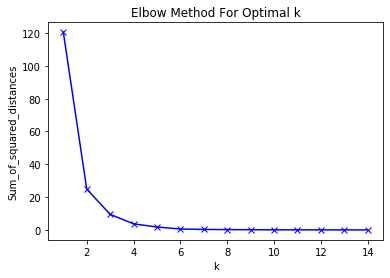

In [39]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [40]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_ADNeighbourhoods_clust)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 1, 2, 1, 0, 0, 2, 0, 0])

In [41]:
# add clustering labels
df_ADNeighbourhoods_clustering = df_ADNeighbourhoods
df_ADNeighbourhoods_clustering.insert(1, 'ClusterLabels', kmeans.labels_)

In [42]:
df_ADNeighbourhoods_clustering.head()

,Neighborhood,ClusterLabels,lat,lng,poCount
0,Al Aman,0,24.431990,54.426550,1
1,Al Bateen,0,24.451315,54.328144,2
2,Al Dhafrah,1,24.476147,54.369360,5
3,Al Falah,2,24.444696,54.728187,0
4,Al Karamah,1,24.465300,54.371509,4


In [43]:
# Count of Office in Cluster 
df_ADNeighbourhoods_clustering[['ClusterLabels', 'poCount']].groupby(['ClusterLabels']).agg(['count'])


,poCount
,count
ClusterLabels,
0,15
1,9
2,20


In [44]:
# Get Cluster value for 0 Offices 
ClustOffices = (df_ADNeighbourhoods_clustering.loc[df_ADNeighbourhoods_clustering['poCount'] == 0, 'ClusterLabels'].values[0])
print(ClustOffices)

2


In [45]:
# set color scheme for the clusters
rainbow = ['lightgreen','lightblue','lightred']


In [46]:
# create map
map_clusters = folium.Map(location=[ADLat, ADLong], zoom_start=11)

# add the post Offices as orange circle markers
for lat, lng, label,po,ClusterLabels in zip(df_ADNeighbourhoods.lat, df_ADNeighbourhoods.lng, df_ADNeighbourhoods.Neighborhood,df_ADNeighbourhoods.poCount,df_ADNeighbourhoods.ClusterLabels):
    popup_text = """{}<br>Total Post Offices: {}"""
    popup_text = popup_text.format(label,po)
    
    folium.features.Marker([lat, lng],popup=popup_text,icon=folium.Icon(color=rainbow[ClusterLabels], icon='home', prefix='fa')).add_to(map_clusters)


for lat, lng, label,nb in zip(filtered_bayanat_df2.lat, filtered_bayanat_df2.lng, filtered_bayanat_df2.name,filtered_bayanat_df2.nbCount):
    popup_text = """{}<br>Total Neighbourhoods: {}"""
    popup_text = popup_text.format(label,nb)
    
    folium.features.Circle(
        [lat, lng],
        radius=__CoverageRadius,
        color='orange',
        popup=label,
        fill = True,
        fill_color='orange',
        fill_opacity=0.1
    ).add_to(map_clusters)
    folium.features.Marker([lat, lng],popup=popup_text,icon=folium.Icon(color='orange', icon='envelope', prefix='fa')).add_to(map_clusters)

    
for lat, lng in zip(filtered_bayanat_df2.lat, filtered_bayanat_df2.lng):
    p1 = [lat, lng]
    for lt, lg, cl in zip(df_ADNeighbourhoods.lat, df_ADNeighbourhoods.lng,df_ADNeighbourhoods.ClusterLabels):
        p2 = [lt, lg]
        dist=geopy.distance.geodesic(p1,p2).m
        #print(p1,p2,dist)
        if dist <=__CoverageRadius:
            folium.PolyLine(locations=[p1, p2], color=rainbow[cl],weight=3,opacity=0.9).add_to(map_clusters)
# display map
map_clusters




Work on Neighbourhoods with No Post Offices

In [47]:
df_ADNeighbourhoods0 = pd.DataFrame(df_ADNeighbourhoods_clustering[df_ADNeighbourhoods_clustering['ClusterLabels']==ClustOffices])
df_ADNeighbourhoods0.head()

,Neighborhood,ClusterLabels,lat,lng,poCount
3,Al Falah,2,24.444696,54.728187,0
7,Al Madina,2,24.340878,54.490708,0
11,Al Maqta,2,24.407985,54.499372,0
13,Al Mina,2,24.520660,54.372529,0
15,Al Mushrif,2,24.436912,54.391006,0


In [48]:
df_ADNeighbourhoods0.drop(['ClusterLabels', 'poCount'], axis=1, inplace=True)

In [49]:
df_ADNeighbourhoods0.head()

,Neighborhood,lat,lng
3,Al Falah,24.444696,54.728187
7,Al Madina,24.340878,54.490708
11,Al Maqta,24.407985,54.499372
13,Al Mina,24.520660,54.372529
15,Al Mushrif,24.436912,54.391006


In [50]:
map_ADNeighbourhoods0 = folium.Map(location=[ADLat, ADLong], zoom_start=11) # generate map centred around the Conrad Hotel

# add the post Offices as orange circle markers
for lat, lng, label in zip(df_ADNeighbourhoods0.lat, df_ADNeighbourhoods0.lng, df_ADNeighbourhoods0.Neighborhood):

    folium.features.Marker([lat, lng],popup=label,icon=folium.Icon(color="lightred", icon='home', prefix='fa')).add_to(map_ADNeighbourhoods0)


for lat, lng, label in zip(filtered_bayanat_df2.lat, filtered_bayanat_df2.lng, filtered_bayanat_df2.name):
    folium.features.Circle(
        [lat, lng],
        radius=__CoverageRadius,
        color='orange',
        popup=label,
        fill = True,
        fill_color='orange',
        fill_opacity=0.2
    ).add_to(map_ADNeighbourhoods0)
    
    folium.features.Marker([lat, lng],popup=label,icon=folium.Icon(color='orange', icon='envelope', prefix='fa')).add_to(map_ADNeighbourhoods0)

# display map
map_ADNeighbourhoods0

In [51]:
df_ADNeighbourhoods0Test = pd.DataFrame(df_ADNeighbourhoods0) 

In [52]:
df_ADNeighbourhoods0Test.drop(['Neighborhood'], axis=1, inplace=True)

In [53]:
df_ADNeighbourhoods0Test.head()

,lat,lng
3,24.444696,54.728187
7,24.340878,54.490708
11,24.407985,54.499372
13,24.520660,54.372529
15,24.436912,54.391006


In [54]:
df_ADNeighbourhoods0.head()

,Neighborhood,lat,lng
3,Al Falah,24.444696,54.728187
7,Al Madina,24.340878,54.490708
11,Al Maqta,24.407985,54.499372
13,Al Mina,24.520660,54.372529
15,Al Mushrif,24.436912,54.391006


In [55]:
def TestClusters(cls):
    df_Test0Clust = df_ADNeighbourhoods0.copy()
    df_Test0Clust.drop(['Neighborhood'], axis=1, inplace=True)

    kms = KMeans(n_clusters=cls,random_state=0).fit(df_Test0Clust)

    df_Test0Clust = df_ADNeighbourhoods0.copy()
    df_Test0Clust.insert(0, 'ClusterLabels', kms.labels_)
    return df_Test0Clust,kms

In [103]:
def PlotMap(df,kmObj):
    m = folium.Map(location=[ADLat, ADLong], zoom_start=10) # generate map centred around the Conrad Hotel
    cols = ['red', 'blue', 'green', 'purple', 'gray', 'darkred','pink', 'lightblue','lightred', 'darkblue', 'darkgreen', 'darkpurple', 'white', 'lightgreen', 'black', 'lightgray','cadetblue','beige','orange']

    # Add Neighborhood
    for lat, lng, label,cl in zip(df.lat, df.lng, df.Neighborhood,df.ClusterLabels):
        lbl = label + ': Cluster ' + str(cl)
        folium.features.Marker([lat, lng],popup=lbl,icon=folium.Icon(color=cols[cl], icon='home', prefix='fa')).add_to(m)

    # Add Cluster centers
    for i in range(len(kmObj.cluster_centers_)):
        folium.features.CircleMarker(
            kmObj.cluster_centers_[i],
            radius=5,
            color=cols[i],
            popup=label,
            fill = True,
            fill_color=cols[i],
            fill_opacity=0.6
        ).add_to(m)
    
        folium.features.Circle(
            kmObj.cluster_centers_[i],
            radius=__CoverageRadius,
            weight=1,
            color=cols[i],
            popup=label,
            fill = True,
            fill_color=cols[i],
        fill_opacity=0.2
        ).add_to(m)
           
        # Draw Lines
        p1=[kmObj.cluster_centers_[i][0],kmObj.cluster_centers_[i][1]]       
        for lt, lg,cl in zip(df.lat, df.lng,df.ClusterLabels):
            if cl == i:
                p2 = [lt, lg]
                dist=geopy.distance.geodesic(p1,p2).m
                if dist <=__CoverageRadius:
                    folium.PolyLine(
                        locations=[p1, p2],
                        color=cols[i],
                        weight=5, 
                        opacity=1
                    ).add_to(m)
                else:
                    folium.PolyLine(
                        locations=[p1, p2],
                        color=cols[i],
                        weight=2, 
                        opacity=0.5
                    ).add_to(m)
        # Draw Cluster Label
        folium.map.Marker(
            [kmObj.cluster_centers_[i][0]-0.001,kmObj.cluster_centers_[i][1]+0.001],
            icon=DivIcon(
                icon_size=(150,36),
                icon_anchor=(0,0),
                html='<div style="font-size: 14pt;color: {}">Cluster: {}</div>'.format(cols[i],i),
                )
        ).add_to(m)
# display map
    return m

In [57]:
def Effecancy(dfClust,kmObj):
    df = pd.DataFrame(columns=["Cluster", "TotalNeighborhoods", "TotalCovered"]) 
    df = df.astype({"Cluster": int, "TotalNeighborhoods": int, "TotalCovered": int})
    
    for i in range(len(kmObj.cluster_centers_)):
        p1 = [kmObj.cluster_centers_[i][0],kmObj.cluster_centers_[i][1]]
        subDF = pd.DataFrame(dfClust[dfClust['ClusterLabels']==i])
        
        TotalNeighborhoods = subDF.shape[0]

        TotalCovered=0
        for index, row in subDF.iterrows():
            p2 = (row["lat"], row["lng"])
            if geopy.distance.geodesic(p1, p2).m <=__CoverageRadius:
                TotalCovered = TotalCovered + 1
        df = df.append({'Cluster' : i , 'TotalNeighborhoods' : TotalNeighborhoods, 'TotalCovered' : TotalCovered}, ignore_index=True)
#     df = df.append(df.sum(numeric_only=True), ignore_index=True)
    return df

In [58]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_ADNeighbourhoods0Test)
    Sum_of_squared_distances.append(km.inertia_)

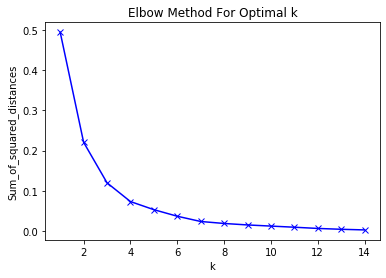

In [59]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

## More Data Analysis

In [82]:
clusters = 5

In [83]:
df_Test0Clust, KMObj = TestClusters(clusters)

In [104]:
PlotMap(df_Test0Clust,KMObj)

In [85]:
def ClusterCoverage(clust):
    df_Test, KMtest = TestClusters(clust)
    df_e = Effecancy(df_Test,KMtest)
    TotalCoverage = (df_e.loc[:,'TotalCovered'].sum(axis = 0) / df_e.loc[:,'TotalNeighborhoods'].sum(axis = 0))*100
    return TotalCoverage

In [86]:
cav = ClusterCoverage(clusters)
print("{} Clusters Covers {}% of uncovered Neighborhoods".format(clusters,cav))

5 Clusters Covers 10.0% of uncovered Neighborhoods


In [87]:
sssss = Effecancy(df_Test0Clust,KMObj)
sssss

,Cluster,TotalNeighborhoods,TotalCovered
0,0,6,0
1,1,6,1
2,2,2,0
3,3,3,1
4,4,3,0


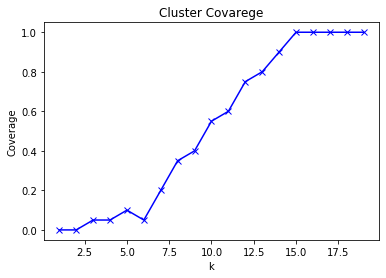

In [76]:
ClusterCoverage = []
kk = range(1,20)
for k in kk:
    df_Test, KMtest = TestClusters(k)
    df_e = Effecancy(df_Test,KMtest)
    TotalCoverage = df_e.loc[:,'TotalCovered'].sum(axis = 0) / df_e.loc[:,'TotalNeighborhoods'].sum(axis = 0)
    ClusterCoverage.append(TotalCoverage)
plt.plot(kk, ClusterCoverage, 'bx-')
plt.xlabel('k')
plt.ylabel('Coverage')
plt.title('Cluster Covarege')
plt.show()

In [108]:
cav = ClusterCoverage(15)
print("{} Clusters Covers {}% of uncovered Neighborhoods".format(clusters,cav))

15 Clusters Covers 100.0% of uncovered Neighborhoods


In [105]:
clusters = 15
df_Test0Clust, KMObj = TestClusters(clusters)
PlotMap(df_Test0Clust,KMObj)